# Rasterization

In [400]:
from __future__ import annotations

from PIL import Image
from pyrr import Matrix44

import moderngl as mgl
import numpy as np


def show_fbo(fbo: mgl.Framebuffer, size: tuple[int], color_mode: str) -> None:
    img = Image.frombytes(color_mode, size, fbo.read(components=len(color_mode)))
    img = img.transpose(Image.FLIP_TOP_BOTTOM)
    display(img)


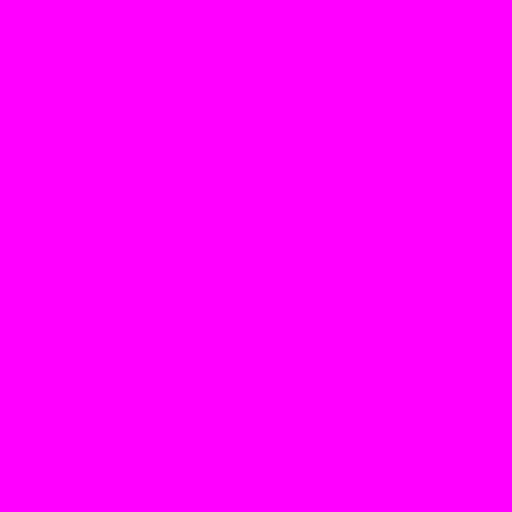

In [401]:
SIZE = WIDTH, HEIGHT = 512, 512
COLOR_MODE = "RGBA"

ctx = mgl.create_context(standalone=True, backend="egl")
fbo = ctx.simple_framebuffer(SIZE, components=len(COLOR_MODE))
fbo.use()

ctx.clear(1.0, 0.0, 1.0, 1.0)
show_fbo(fbo, SIZE, COLOR_MODE)

In [402]:
VS = """
#version 330

in vec3 in_vert;
in vec3 in_color;

out vec3 v_color;

void main() {
    gl_Position = vec4(in_vert, 1.0f);
    v_color = in_color;
}
"""

In [403]:
FS = """
#version 330

in vec3 v_color;

out vec4 f_color;

void main() {
    f_color = vec4(v_color, 1.0f);
}
"""

In [404]:
prog = ctx.program(vertex_shader=VS, fragment_shader=FS)

In [405]:
vbo = ctx.buffer(np.array([
    # x     y    z     r    g    b
    -0.5, -0.5, 0.0,  1.0, 0.0, 0.0,
     0.5, -0.5, 0.0,  0.0, 1.0, 0.0,
     0.0,  0.5, 0.0,  0.0, 0.0, 1.0,
], dtype=np.float32))

In [406]:
vao = ctx.vertex_array(prog, [(vbo, "3f 3f", "in_vert", "in_color")])

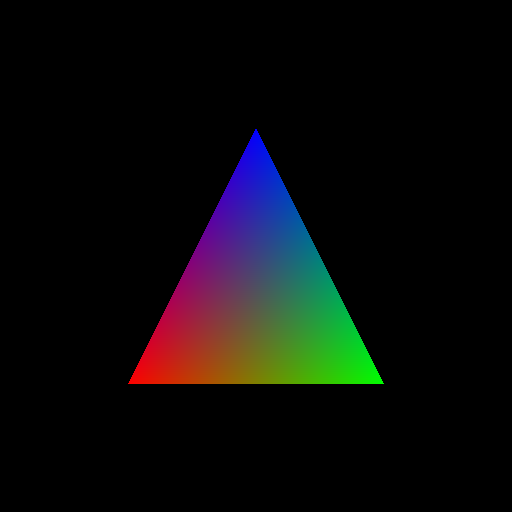

In [407]:
ctx.clear(0.0, 0.0, 0.0, 1.0)
vao.render(mode=mgl.TRIANGLES)
show_fbo(fbo, SIZE, COLOR_MODE)

In [408]:
VS = """
#version 330

in vec3 in_vert;
in vec2 in_uv;

out vec2 v_uv;

void main() {
    gl_Position = vec4(in_vert, 1.0f);
    v_uv = in_uv;
}
"""

In [409]:
FS = """
#version 330

in vec2 v_uv;

out vec4 f_color;

void main() {
    f_color = vec4(v_uv, 0.0f, 1.0f);
}
"""

In [410]:
prog = ctx.program(vertex_shader=VS, fragment_shader=FS)

In [411]:
vbo = ctx.buffer(np.array([
    # x     y    z     u    v  
     0.5,  0.5, 0.0,  1.0, 1.0,
     0.5, -0.5, 0.0,  1.0, 0.0,
    -0.5, -0.5, 0.0,  0.0, 0.0,
    -0.5,  0.5, 0.0,  0.0, 1.0,
], dtype=np.float32))

In [412]:
ibo = ctx.buffer(np.array([
    0, 1, 3,
    1, 2, 3,
], dtype=np.int32))

In [413]:
vao = ctx.vertex_array(prog, [(vbo, "3f 2f", "in_vert", "in_uv")], ibo)

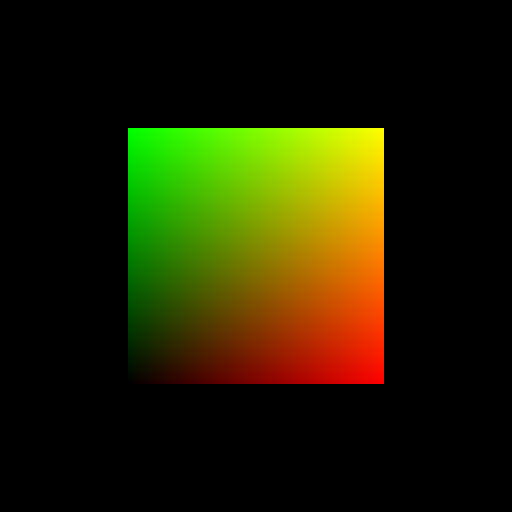

In [414]:
ctx.clear(0.0, 0.0, 0.0, 1.0)
vao.render(mode=mgl.TRIANGLES)
show_fbo(fbo, SIZE, COLOR_MODE)

In [415]:
VS = """
#version 330

in vec3 in_vert;
in vec2 in_uv;

out vec2 v_uv;

void main() {
    gl_Position = vec4(in_vert, 1.0f);
    v_uv = in_uv;
}
"""

In [416]:
FS = """
#version 330

uniform sampler2D texture;

in vec2 v_uv;

out vec4 f_color;

void main() {
    f_color = vec4(texture2D(texture, v_uv).rgb, 1.0f);
}
"""

In [417]:
prog = ctx.program(vertex_shader=VS, fragment_shader=FS)

In [418]:
vao = ctx.vertex_array(prog, [(vbo, "3f 2f", "in_vert", "in_uv")], ibo)

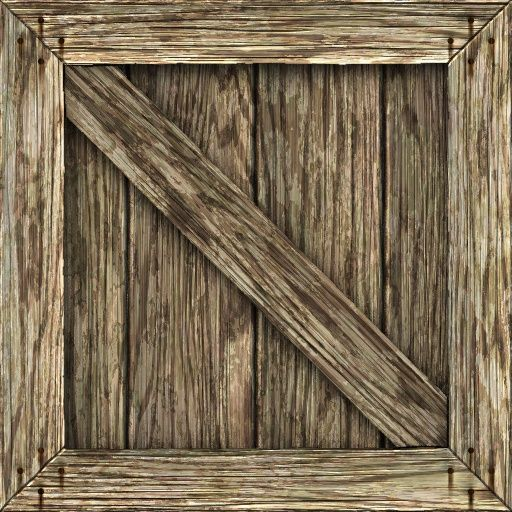

In [419]:
img = Image.open("box.jpg")
img

In [420]:
texture = ctx.texture(img.size, 3, img.tobytes(), alignment=4)
texture.use()

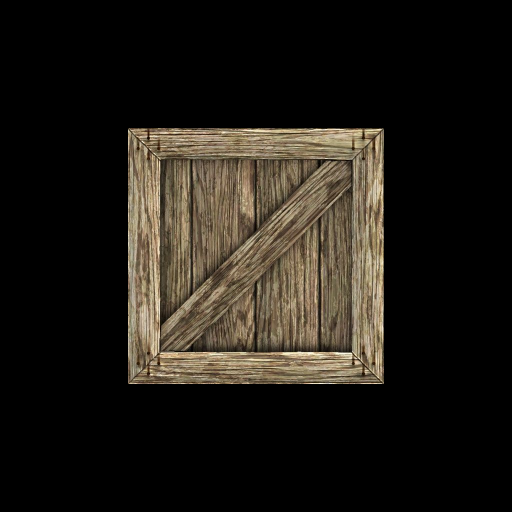

In [421]:
ctx.clear(0.0, 0.0, 0.0, 1.0)
vao.render(mode=mgl.TRIANGLES)
show_fbo(fbo, SIZE, COLOR_MODE)

In [422]:
VS = """
#version 330

uniform mat4 mvp;

in vec3 in_vert;
in vec2 in_uv;

out vec2 v_uv;

void main() {
    gl_Position = mvp * vec4(in_vert, 1.0f);
    v_uv = in_uv;
}
"""

In [423]:
FS = """
#version 330

uniform sampler2D texture;

in vec2 v_uv;

out vec4 f_color;

void main() {
    f_color = vec4(texture2D(texture, v_uv).rgb, 1.0f);
}
"""

In [424]:
look_at = Matrix44.look_at((2.0, 1.5, 1.5), (0.0, 0.0, 0.0), (0.0, 1.0, 0.0))
proj = Matrix44.perspective_projection(45.0, WIDTH / HEIGHT, 1e-1, 1e3)

In [425]:
prog = ctx.program(vertex_shader=VS, fragment_shader=FS)
prog["mvp"].write((proj * look_at).astype("f4"))

In [426]:
vao = ctx.vertex_array(prog, [(vbo, "3f 2f", "in_vert", "in_uv")], ibo)

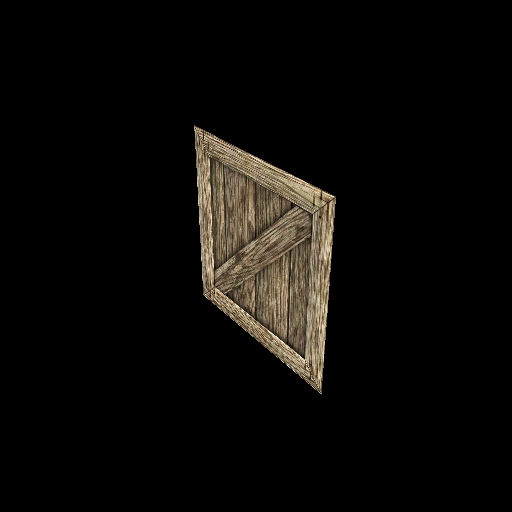

In [427]:
ctx.clear(0.0, 0.0, 0.0, 1.0)
vao.render(mode=mgl.TRIANGLES)
show_fbo(fbo, SIZE, COLOR_MODE)

In [428]:
vbo = ctx.buffer(np.array([
    # x     y     z     u    v
    +0.5, -0.5, +0.5,  1.0, 0.0,
    +0.5, +0.5, +0.5,  1.0, 1.0,
    -0.5, -0.5, +0.5,  0.0, 0.0,
    +0.5, +0.5, +0.5,  1.0, 1.0,
    -0.5, +0.5, +0.5,  0.0, 1.0,
    -0.5, -0.5, +0.5,  0.0, 0.0,
    +0.5, -0.5, -0.5,  1.0, 0.0,
    +0.5, +0.5, -0.5,  1.0, 1.0,
    +0.5, -0.5, +0.5,  0.0, 0.0,
    +0.5, +0.5, -0.5,  1.0, 1.0,
    +0.5, +0.5, +0.5,  0.0, 1.0,
    +0.5, -0.5, +0.5,  0.0, 0.0,
    +0.5, -0.5, -0.5,  1.0, 1.0,
    +0.5, -0.5, +0.5,  0.0, 1.0,
    -0.5, -0.5, +0.5,  0.0, 0.0,
    +0.5, -0.5, -0.5,  1.0, 1.0,
    -0.5, -0.5, +0.5,  0.0, 0.0,
    -0.5, -0.5, -0.5,  1.0, 0.0,
    -0.5, -0.5, +0.5,  0.0, 1.0,
    -0.5, +0.5, +0.5,  0.0, 0.0,
    -0.5, +0.5, -0.5,  1.0, 0.0,
    -0.5, -0.5, +0.5,  0.0, 1.0,
    -0.5, +0.5, -0.5,  1.0, 0.0,
    -0.5, -0.5, -0.5,  1.0, 1.0,
    +0.5, +0.5, -0.5,  1.0, 0.0,
    +0.5, -0.5, -0.5,  1.0, 1.0,
    -0.5, -0.5, -0.5,  0.0, 1.0,
    +0.5, +0.5, -0.5,  1.0, 0.0,
    -0.5, -0.5, -0.5,  0.0, 1.0,
    -0.5, +0.5, -0.5,  0.0, 0.0,
    +0.5, +0.5, -0.5,  1.0, 1.0,
    -0.5, +0.5, -0.5,  0.0, 1.0,
    +0.5, +0.5, +0.5,  1.0, 0.0,
    -0.5, +0.5, -0.5,  0.0, 1.0,
    -0.5, +0.5, +0.5,  0.0, 0.0,
    +0.5, +0.5, +0.5,  1.0, 0.0,
], dtype=np.float32))

In [429]:
vao = ctx.vertex_array(prog, [(vbo, "3f 2f", "in_vert", "in_uv")])

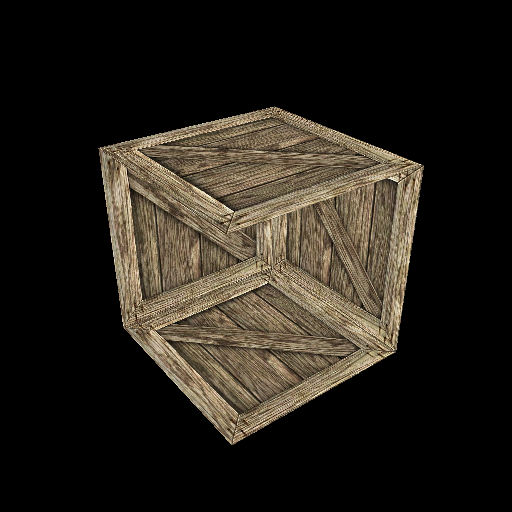

In [430]:
ctx.clear(0.0, 0.0, 0.0, 1.0)
vao.render(mode=mgl.TRIANGLES)
show_fbo(fbo, SIZE, COLOR_MODE)

In [431]:
ctx.enable(mgl.DEPTH_TEST | mgl.CULL_FACE)

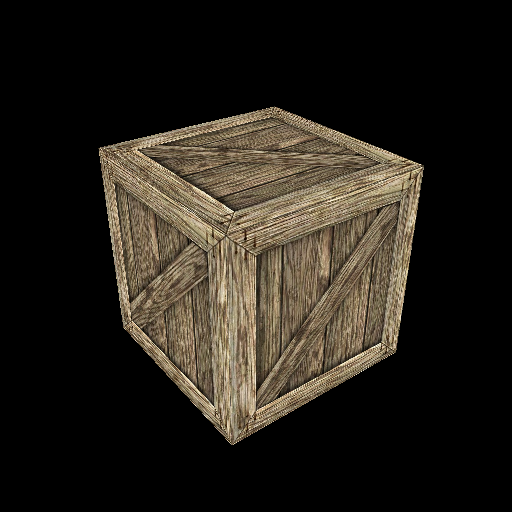

In [432]:
ctx.clear(0.0, 0.0, 0.0, 1.0)
vao.render(mode=mgl.TRIANGLES)
show_fbo(fbo, SIZE, COLOR_MODE)

In [433]:
VS = """
#version 330

uniform mat4 mvp;

in vec3 in_vert;
in vec2 in_uv;
in vec3 in_norm;

out vec2 v_uv;
out vec3 v_norm;

void main() {
    gl_Position = mvp * vec4(in_vert, 1.0f);
    v_uv = in_uv;
    v_norm = in_norm;
}
"""

In [434]:
FS = """
#version 330

uniform sampler2D texture;

in vec2 v_uv;
in vec3 v_norm;

out vec4 f_color;

void main() {
    f_color = vec4(0.5 * texture2D(texture, v_uv).rgb + 0.5 * v_norm, 1.0f);
}
"""

In [435]:
prog = ctx.program(vertex_shader=VS, fragment_shader=FS)
prog["mvp"].write((proj * look_at).astype("f4"))

In [436]:
vbo = ctx.buffer(np.array([
    # x     y     z     u    v     nx    ny    nz
    +0.5, -0.5, +0.5,  1.0, 0.0,  -0.0,  0.0,  1.0,
    +0.5, +0.5, +0.5,  1.0, 1.0,  -0.0,  0.0,  1.0,
    -0.5, -0.5, +0.5,  0.0, 0.0,  -0.0,  0.0,  1.0,
    +0.5, +0.5, +0.5,  1.0, 1.0,   0.0,  0.0,  1.0,
    -0.5, +0.5, +0.5,  0.0, 1.0,   0.0,  0.0,  1.0,
    -0.5, -0.5, +0.5,  0.0, 0.0,   0.0,  0.0,  1.0,
    +0.5, -0.5, -0.5,  1.0, 0.0,   1.0,  0.0,  0.0,
    +0.5, +0.5, -0.5,  1.0, 1.0,   1.0,  0.0,  0.0,
    +0.5, -0.5, +0.5,  0.0, 0.0,   1.0,  0.0,  0.0,
    +0.5, +0.5, -0.5,  1.0, 1.0,   1.0,  0.0,  0.0,
    +0.5, +0.5, +0.5,  0.0, 1.0,   1.0,  0.0,  0.0,
    +0.5, -0.5, +0.5,  0.0, 0.0,   1.0,  0.0,  0.0,
    +0.5, -0.5, -0.5,  1.0, 1.0,   0.0, -1.0,  0.0,
    +0.5, -0.5, +0.5,  0.0, 1.0,   0.0, -1.0,  0.0,
    -0.5, -0.5, +0.5,  0.0, 0.0,   0.0, -1.0,  0.0,
    +0.5, -0.5, -0.5,  1.0, 1.0,   0.0, -1.0,  0.0,
    -0.5, -0.5, +0.5,  0.0, 0.0,   0.0, -1.0,  0.0,
    -0.5, -0.5, -0.5,  1.0, 0.0,   0.0, -1.0,  0.0,
    -0.5, -0.5, +0.5,  0.0, 1.0,  -1.0, -0.0,  0.0,
    -0.5, +0.5, +0.5,  0.0, 0.0,  -1.0, -0.0,  0.0,
    -0.5, +0.5, -0.5,  1.0, 0.0,  -1.0, -0.0,  0.0,
    -0.5, -0.5, +0.5,  0.0, 1.0,  -1.0, -0.0,  0.0,
    -0.5, +0.5, -0.5,  1.0, 0.0,  -1.0, -0.0,  0.0,
    -0.5, -0.5, -0.5,  1.0, 1.0,  -1.0, -0.0,  0.0,
    +0.5, +0.5, -0.5,  1.0, 0.0,   0.0,  0.0, -1.0,
    +0.5, -0.5, -0.5,  1.0, 1.0,   0.0,  0.0, -1.0,
    -0.5, -0.5, -0.5,  0.0, 1.0,   0.0,  0.0, -1.0,
    +0.5, +0.5, -0.5,  1.0, 0.0,   0.0,  0.0, -1.0,
    -0.5, -0.5, -0.5,  0.0, 1.0,   0.0,  0.0, -1.0,
    -0.5, +0.5, -0.5,  0.0, 0.0,   0.0,  0.0, -1.0,
    +0.5, +0.5, -0.5,  1.0, 1.0,   0.0,  1.0,  0.0,
    -0.5, +0.5, -0.5,  0.0, 1.0,   0.0,  1.0,  0.0,
    +0.5, +0.5, +0.5,  1.0, 0.0,   0.0,  1.0,  0.0,
    -0.5, +0.5, -0.5,  0.0, 1.0,   0.0,  1.0,  0.0,
    -0.5, +0.5, +0.5,  0.0, 0.0,   0.0,  1.0,  0.0,
    +0.5, +0.5, +0.5,  1.0, 0.0,   0.0,  1.0,  0.0,
], dtype=np.float32))

In [437]:
vao = ctx.vertex_array(prog, [(vbo, "3f 2f 3f", "in_vert", "in_uv", "in_norm")])

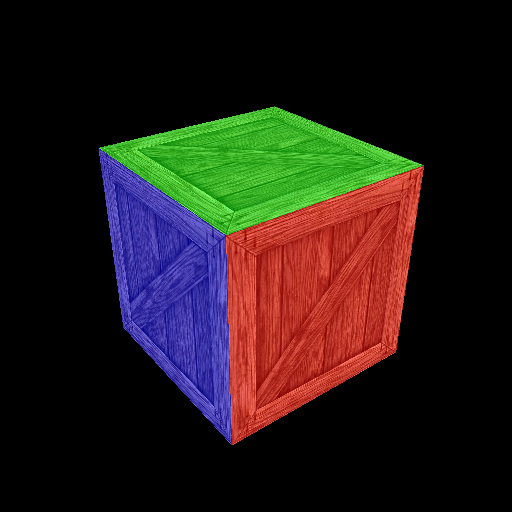

In [438]:
ctx.clear(0.0, 0.0, 0.0, 1.0)
vao.render(mode=mgl.TRIANGLES)
show_fbo(fbo, SIZE, COLOR_MODE)

In [475]:
FS = """
#version 330

uniform sampler2D texture;

in vec2 v_uv;
in vec3 v_norm;

out vec4 f_color;

float l_intensity = 1.0;
vec3 l_pos = vec3(-2.0, -4.0, -2.0);
vec3 l_dir = normalize(-l_pos);

void main() {
    vec3 albedo = texture2D(texture, v_uv).rgb;
    vec3 diffuse = albedo * l_intensity * clamp(dot(v_norm, l_dir), 0.0, 1.0);
    f_color = vec4(diffuse, 1.0f);
}
"""

In [476]:
prog = ctx.program(vertex_shader=VS, fragment_shader=FS)
prog["mvp"].write((proj * look_at).astype("f4"))

In [477]:
vao = ctx.vertex_array(prog, [(vbo, "3f 2f 3f", "in_vert", "in_uv", "in_norm")])

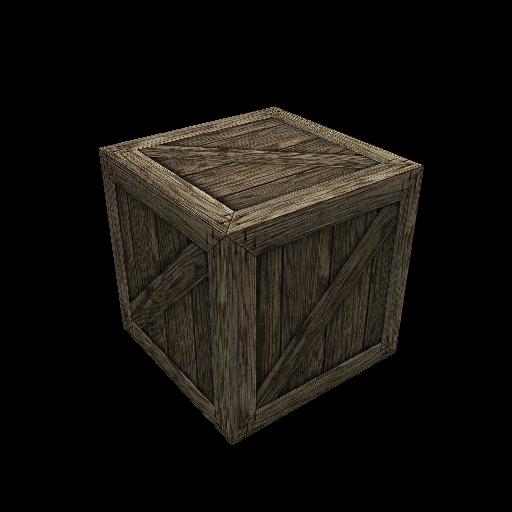

In [478]:
ctx.clear(0.0, 0.0, 0.0, 1.0)
vao.render(mode=mgl.TRIANGLES)
show_fbo(fbo, SIZE, COLOR_MODE)

In [507]:
def load_obj(path: str) -> tuple[np.ndarray, np.ndarray]:
    vert, norm, idxs = [], [], []
    with open("suzanne.obj") as fp:
        for line in fp.readlines():
            if line.startswith("v "): vert.append(list(map(float, line[2:].split(" "))))
            if line.startswith("vn "): norm.append(list(map(float, line[3:].split(" "))))
            if line.startswith("f "):
                idxs += list(map(int, [e for face in line[2:].split(" ") for e in face.split("/")]))

    data = [e for v, n in zip(vert, norm) for e in v + n]
    data = np.array(data, dtype=np.float32)
    idxs = np.array(idxs, dtype=np.int32)
    
    return data, idxs

In [508]:
suzanne_data, suzanne_idxs = load_obj("suzanne.obj")
suzanne_data.shape, suzanne_idxs.shape

((47748,), (94464,))

In [514]:
VS = """
#version 330

uniform mat4 mvp;

in vec3 in_vert;
in vec3 in_norm;

out vec3 v_norm;

void main() {
    gl_Position = mvp * vec4(in_vert, 1.0f);
    v_norm = in_norm;
}
"""

In [515]:
FS = """
#version 330

in vec3 v_norm;

out vec4 f_color;

float l_intensity = 1.0;
vec3 l_pos = vec3(-2.0, -4.0, -2.0);
vec3 l_dir = normalize(-l_pos);

void main() {
    vec3 diffuse = vec3(1.0, 1.0, 1.0) * l_intensity * clamp(dot(v_norm, l_dir), 0.0, 1.0);
    f_color = vec4(diffuse, 1.0f);
}
"""

In [516]:
vbo = ctx.buffer(suzanne_data)
ibo = ctx.buffer(suzanne_idxs)
vao = ctx.vertex_array(prog, [(vbo, "3f 3f", "in_vert", "in_norm")])

In [517]:
prog = ctx.program(vertex_shader=VS, fragment_shader=FS)
prog["mvp"].write((proj * look_at).astype("f4"))

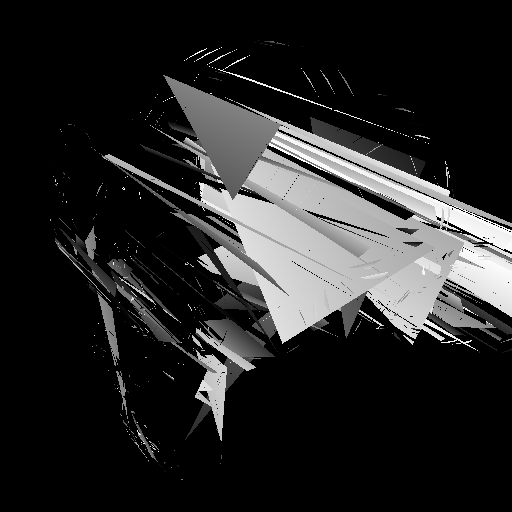

In [518]:
ctx.clear(0.0, 0.0, 0.0, 1.0)
vao.render(mode=mgl.TRIANGLES)
show_fbo(fbo, SIZE, COLOR_MODE)